# Stock Market Prediction Using LSTM

In [2]:
# Importing Libraries

In [130]:
import datetime as dt
import math
import numpy as np # for linear algebra
import pandas as pd # for importing and manipulating dataset
import seaborn as sns # for plotting
import matplotlib.pyplot as plt # for plotting
%matplotlib inline 
# displays the plot just below the cell in which it was called.

In [4]:
# Importing the dataset
db = pd.read_csv('AAP.csv')

## Exploratory Data Analysis

In [5]:
db.head()

,Date,Low,Open,Volume,High,Close,Adjusted Close
0,29-11-2001,13.360000,13.386667,371100,14.466667,13.880000,12.583543
1,30-11-2001,13.880000,13.880000,165300,14.266667,14.266667,12.934094
2,03-12-2001,13.783333,14.233333,127500,14.233333,13.783333,12.495903
3,04-12-2001,13.233333,13.783333,95400,13.783333,13.233333,11.997280
4,05-12-2001,13.433333,13.433333,598200,14.783333,14.666667,13.296731


In [6]:
db.describe()

,Low,Open,Volume,High,Close,Adjusted Close
count,5296.000000,5296.000000,5.296000e+03,5296.000000,5296.000000,5296.000000
mean,90.334993,91.457988,1.172949e+06,92.530779,91.453034,86.724356
std,60.561938,61.302219,9.537457e+05,61.976656,61.282078,59.505903
min,12.330000,12.550000,9.000000e+03,12.663333,12.526667,11.356615
25%,36.789999,37.349998,6.822375e+05,37.807501,37.277499,34.040409
50%,71.255001,71.940002,9.502000e+05,72.469997,71.934998,67.526833
75%,148.767494,150.745003,1.373138e+06,152.580006,150.612499,143.433201
max,240.320007,241.160004,1.974950e+07,244.550003,241.910004,235.716782


In [7]:
# Checking for NaN values
db.isnull().sum()

Date              0
Low               0
Open              0
Volume            0
High              0
Close             0
Adjusted Close    0
dtype: int64

###  we have no missing values in our dataset

In [8]:
db.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5296 entries, 0 to 5295
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Date            5296 non-null   object 
 1   Low             5296 non-null   float64
 2   Open            5296 non-null   float64
 3   Volume          5296 non-null   int64  
 4   High            5296 non-null   float64
 5   Close           5296 non-null   float64
 6   Adjusted Close  5296 non-null   float64
dtypes: float64(5), int64(1), object(1)
memory usage: 289.8+ KB


In [9]:
db.shape

(5296, 7)

In [10]:
# Converting 'Date' column from 'object' to python 'Datetime Object'
db['Date'] = pd.to_datetime(db['Date'], format = "%d-%m-%Y")

In [11]:
db.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5296 entries, 0 to 5295
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Date            5296 non-null   datetime64[ns]
 1   Low             5296 non-null   float64       
 2   Open            5296 non-null   float64       
 3   Volume          5296 non-null   int64         
 4   High            5296 non-null   float64       
 5   Close           5296 non-null   float64       
 6   Adjusted Close  5296 non-null   float64       
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 289.8 KB


## Data Visualization

### Opening Price

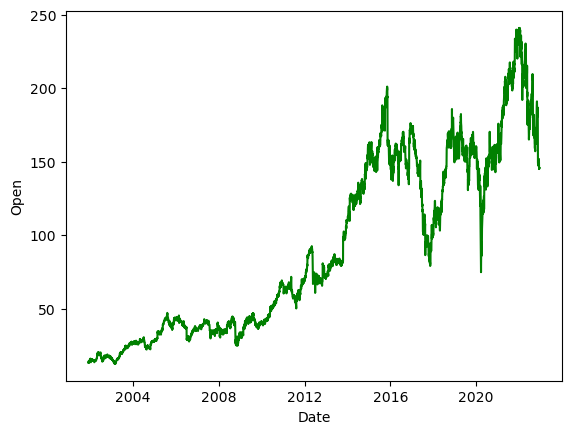

In [12]:
sns.lineplot(x = 'Date', y = 'Open', data = db, color = 'green')
#sns.lineplot(x = 'Date', y = 'Low', data = db)
plt.show()

### Closing Price

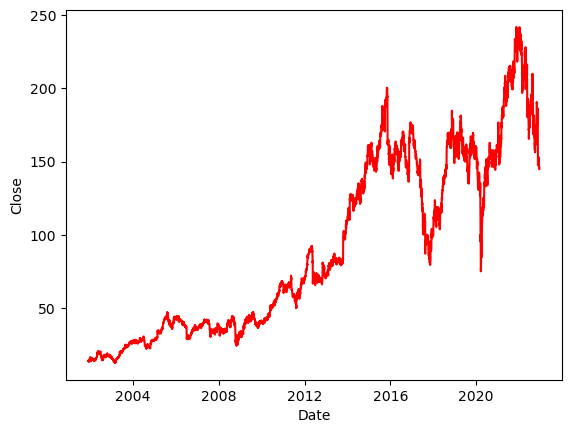

In [13]:
sns.lineplot(x = 'Date', y = 'Close', data = db, color = 'red')
plt.show()

In [14]:
# Getting the maximum values for each column by year
db_max = db.groupby(db['Date'].dt.year).max()
db_max.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22 entries, 2001 to 2022
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Date            22 non-null     datetime64[ns]
 1   Low             22 non-null     float64       
 2   Open            22 non-null     float64       
 3   Volume          22 non-null     int64         
 4   High            22 non-null     float64       
 5   Close           22 non-null     float64       
 6   Adjusted Close  22 non-null     float64       
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 1.4 KB


In [15]:
db_max['Close']

Date
2001     16.583332
2002     20.620001
2003     27.676666
2004     30.606667
2005     47.293331
2006     44.610001
2007     42.259998
2008     44.610001
2009     47.060001
2010     68.540001
2011     72.160004
2012     92.370003
2013    110.680000
2014    161.220001
2015    200.380005
2016    176.779999
2017    174.789993
2018    184.720001
2019    181.429993
2020    162.850006
2021    241.910004
2022    241.649994
Name: Close, dtype: float64

#### Maximum Closing Price By Year

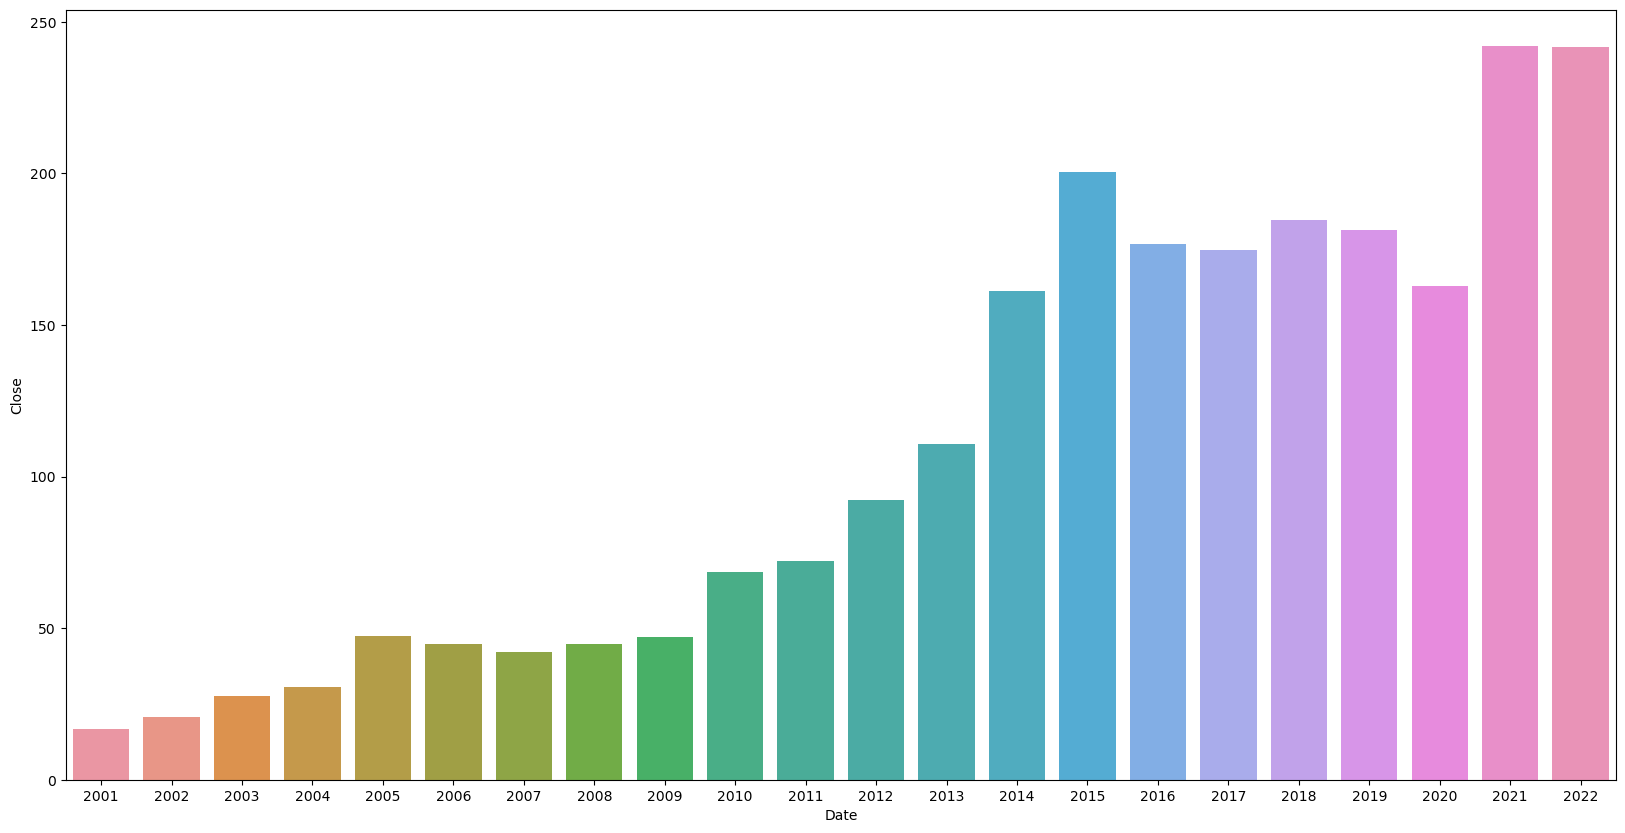

In [16]:
plt.figure(figsize = (20,10))
sns.barplot(x = db_max['Date'].dt.year, y = 'Close', data = db_max)
plt.show()

#### Maximum Volume  By Year

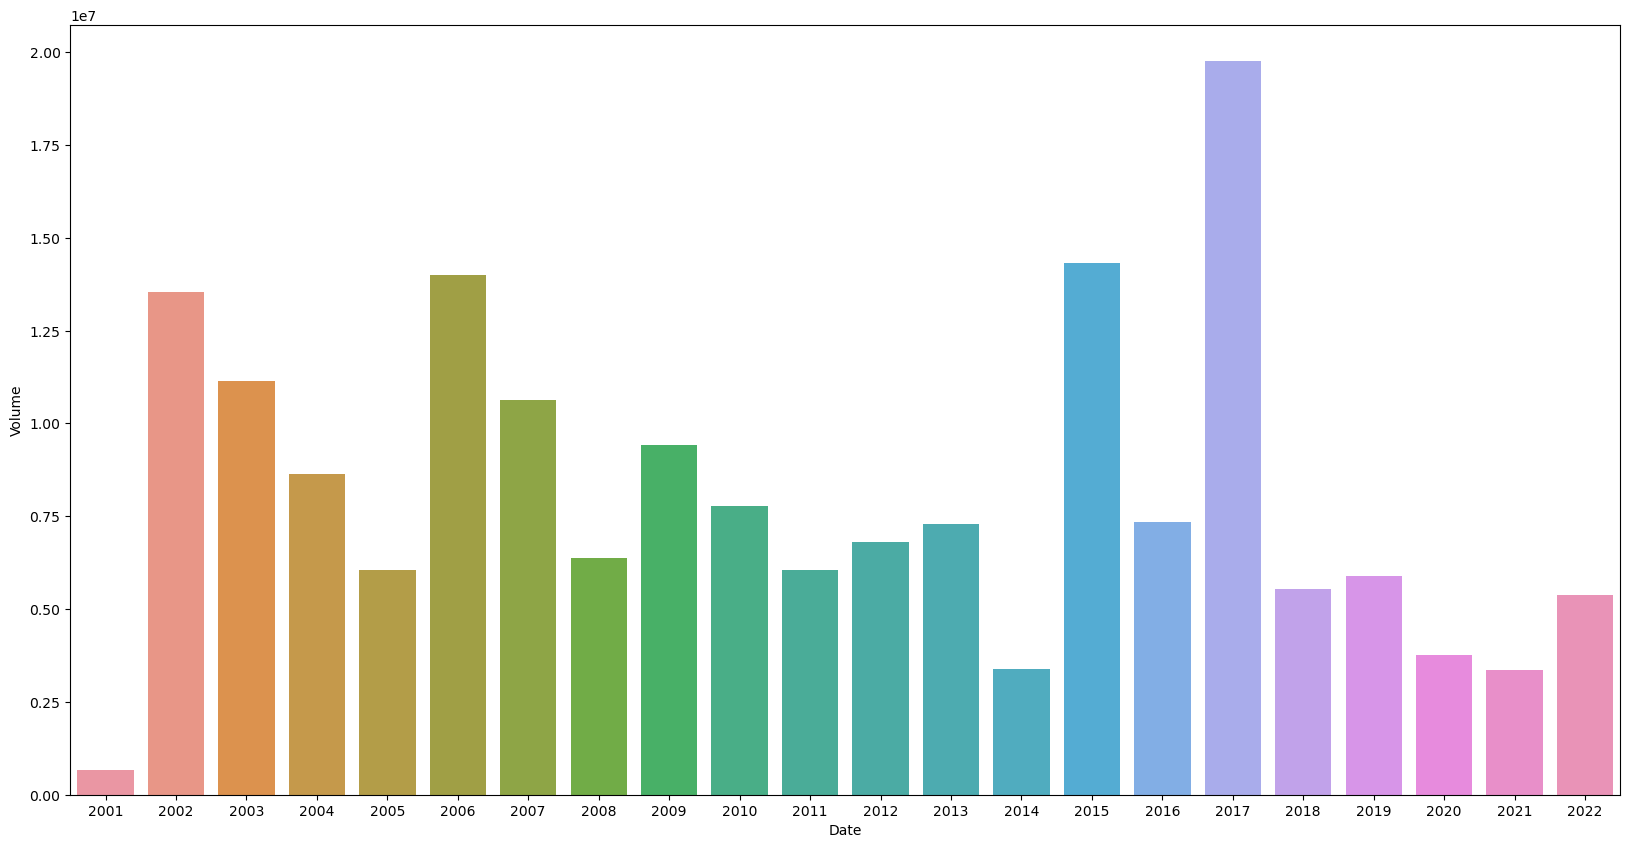

In [17]:
plt.figure(figsize = (20,10))
sns.barplot(x = db_max['Date'].dt.year, y = 'Volume', data = db_max)
plt.show()

## Building the LSTM Model

### Data Preprocessing 

#### Data Normalization

We normalize our data so that our model converges faster and avoids large values from creating bias in the data

Normalization bounds our data between two ranges e.g. [0,1] or [-1,1]

Min-Max Scaler
Transforms features by scaling each feature to a given range. This estimator scales and translates each feature individually such that it is in the given range on the training set, e.g., between zero and one. This Scaler shrinks the data within the range of -1 to 1 if there are negative values. We can set the range like [0,1] or [0,5] or [-1,1].

This Scaler responds well if the standard deviation is small and when a distribution is not Gaussian. This Scaler is sensitive to outliers.

In [62]:
from sklearn.preprocessing import MinMaxScaler

In [102]:
# Normalizing / Scaling the data
db_scaler = MinMaxScaler(feature_range=(0,1)) # scales close prices between 0 and 1
scaled_db = db_scaler.fit_transform(db['Close'].values.reshape(-1,1))

In [103]:
scaled_db

array([[0.00589988],
       [0.00758556],
       [0.00547845],
       ...,
       [0.58445104],
       [0.58144296],
       [0.57725787]])

#### Train-Test Split
Using 80% of data to train the model

In [155]:
close_prices = db['Close']
values = close_prices.values
training_data_len = math.ceil(len(values)* 0.8)
x_train = []
y_train = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])
    
x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

#### Building the LSTM model

In [134]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [146]:
# Build the LSTM model
model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape= (x_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(128, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(1))

In [147]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_15 (LSTM)              (None, 60, 128)           66560     
                                                                 
 dropout_15 (Dropout)        (None, 60, 128)           0         
                                                                 
 lstm_16 (LSTM)              (None, 128)               131584    
                                                                 
 dropout_16 (Dropout)        (None, 128)               0         
                                                                 
 dense_8 (Dense)             (None, 1)                 129       
                                                                 
Total params: 198,273
Trainable params: 198,273
Non-trainable params: 0
_________________________________________________________________


In [148]:
# Define callbacks

# Save best model params
checkpointer = ModelCheckpoint(
    filepath = 'SDM 1\best_hyperparam.hdf5', 
    verbose = 2, 
    save_best_only = True
)

In [149]:
# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

In [150]:
# Train the model
model.fit(x_train, y_train, batch_size=32, epochs=25)

Epoch 1/25
131/131 [==============================] - 22s 130ms/step - loss: 0.0028
Epoch 2/25
131/131 [==============================] - 17s 133ms/step - loss: 7.0501e-04
Epoch 3/25
131/131 [==============================] - 17s 129ms/step - loss: 7.2838e-04
Epoch 4/25
131/131 [==============================] - 17s 127ms/step - loss: 6.6152e-04
Epoch 5/25
131/131 [==============================] - 17s 130ms/step - loss: 5.2912e-04
Epoch 6/25
131/131 [==============================] - 18s 136ms/step - loss: 5.6326e-04
Epoch 7/25
131/131 [==============================] - 19s 144ms/step - loss: 5.4950e-04
Epoch 8/25
131/131 [==============================] - 22s 171ms/step - loss: 5.1759e-04
Epoch 9/25
131/131 [==============================] - 21s 163ms/step - loss: 4.6703e-04
Epoch 10/25
131/131 [==============================] - 20s 153ms/step - loss: 4.8496e-04
Epoch 11/25
131/131 [==============================] - 20s 150ms/step - loss: 4.0959e-04
Epoch 12/25
131/131 [=============

In [151]:
test_data = scaled_db[training_data_len-60: , : ]
x_test = []
y_test = values[training_data_len:]

for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [152]:
predictions = model.predict(x_test)
predictions = db_scaler.inverse_transform(predictions)
rmse = np.sqrt(np.mean(predictions - y_test)**2)
rmse

34/34 [==============================] - 3s 49ms/step


0.961344509106745

C:\Users\jayth\AppData\Local\Temp\ipykernel_21552\224870875.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validation['Predictions'] = predictions


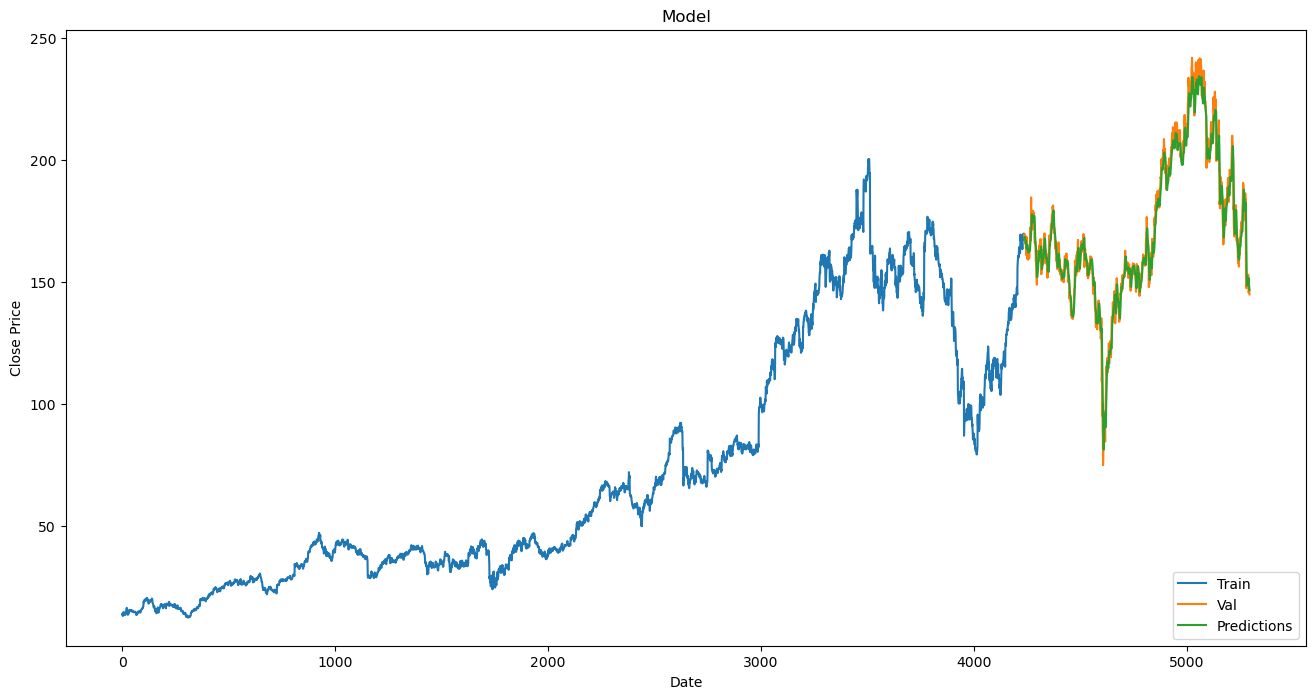

In [158]:

data = db.filter(['Close'])
train = data[:training_data_len]
validation = data[training_data_len:]
validation['Predictions'] = predictions
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.plot(train)
plt.plot(validation[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()